# [Patterning](@id Patterning)

In [2]:
using AgentBasedModels
using GLMakie
using Distributions
GLMakie.inline!(true)

In [3]:
fσ(x) = (1+tanh(2*x))/2
fs0(x,t,l,S0,τg,L) = S0*fσ(1-t/τg)*(exp(-x^2/(2*L^2))+exp(-(1-x)^2/(2*L^2))) + fσ(t/τg-1)*(exp(-x^2/(2*l^2))+exp(-(1-x)^2/(2*l^2)))

fs0 (generic function with 1 method)

In [20]:
model = Agent(2,

    localFloat = [:s0,:u],
    localFloatInteraction = [:s],
    globalFloat = [:a0,:a1,:τ,:l,:D,:S0,:τg,:L],

    updateLocal = quote
        s0 = fs0(x,t,l,S0,τg,L)
    end,

    updateInteraction = quote
        d = minimum(
                [(x.i-x.j)^2+(y.i-y.j)^2,
                (x.i-x.j+1)^2+(y.i-y.j)^2,
                (x.i-x.j-1)^2+(y.i-y.j)^2,
                (x.i-x.j)^2+(y.i-y.j+1)^2,
                (x.i-x.j)^2+(y.i-y.j-1)^2,
                (x.i-x.j+1)^2+(y.i-y.j+1)^2,
                (x.i-x.j+1)^2+(y.i-y.j-1)^2,
                (x.i-x.j-1)^2+(y.i-y.j+1)^2,
                (x.i-x.j-1)^2+(y.i-y.j-1)^2])
        s.i += exp(-d/(2*l^2)) * u.j*(a0 + 3*u.j^3*a1/(1+u.j^2))
    end,
    
    updateVariable = quote 
        
        d( u ) = dt( fσ(2*(u-s-s0))/τ -u/τ ) + dW( D )

    end,

    integrator = :Heun,

);

In [21]:
Lx = 1
Ly = 1
Nx = 18
Ny = 9

com = Community(model,N=[2*Nx*Ny],dt=[0.001])

#Global parameters
λ = 5*10^-6; a0 = .05; a1 = 1 - a0; τ = 1/2; l = 0.085#1.75*λ; 
D = 5*10^-5; S0 = 2; τg = 1; L = .2; N = 324
com[:a0] = a0
com[:a1] = a1
com[:τ] = τ
com[:τg] = τg
com[:l] = l
com[:D] = D
com[:s0] = S0
com[:L] = L

#Positions
dist = Uniform(-1,1)
posx = zeros(2*Nx*Ny); posy = zeros(2*Nx*Ny)
for i in 1:Nx
    for j in 1:Ny
        posx[Nx*(j-1)+i] = Lx*(i-0.5)/Nx +0.01*rand(dist)
        posy[Nx*(j-1)+i] = Ly*(j-0.5)/Ny +0.01*rand(dist)
    end
end
for i in 1:Nx
    for j in 1:Ny
        posx[Nx*Ny+Nx*(j-1)+i] = Lx*(i)/Nx +0.01*rand(dist)
        posy[Nx*Ny+Nx*(j-1)+i] = Ly*(j-0.5+cos(pi/3))/Ny +0.01*rand(dist)
    end
end

com[:x] = posx; com[:y] = posy;
#Concentration
u0 = [fs0(i,0.,l,S0,τg,L) for i in posx]
com[:u] = u0;
com[:s0] = u0;

In [22]:
evolve!(com,steps=1500,saveEach=10,saveCurrentState=true);

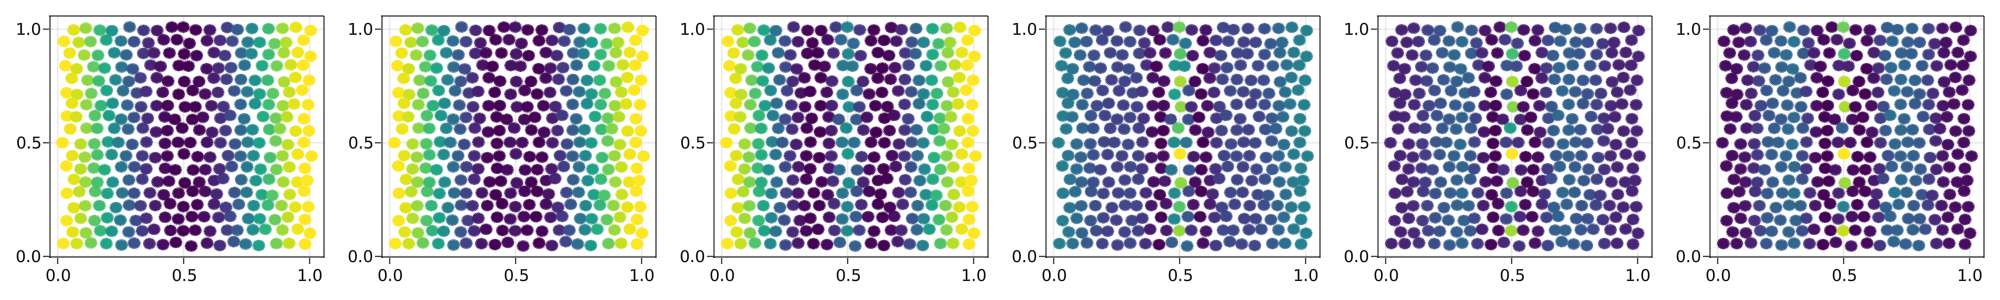

In [23]:
comOut = getParameter(com,[:u])

fig = Figure(resolution=(2000,300))

for (i,time) in enumerate(1:round(Int64,length(com)/5):length(com))
    ax = Axis(fig[1,i])
    meshscatter!(ax,com[:x],com[:y],marker=Circle,markersize=5*10^-2,color=comOut[:u][time])
end

fig

In [24]:
d = getParameter(com,[:t,:u])
for (i,time) in enumerate(1:length(com))
    fig = Figure(resolution=(2000,2000))
    ax = Axis(fig[1,1],title=string("t: ",round(d[:t][time][1],digits=2)),titlesize=70)

    meshscatter!(ax,com[:x],com[:y],marker=Circle,markersize=5*10^-2,color=comOut[:u][time])
    Colorbar(fig[1,2],limits=(0,maximum(comOut[:u][time])),label = "u",labelsize=50,ticklabelsize=50)

    ind = "000$i"
    save("video/Patterning$(ind[end-2:end]).jpeg",fig)
end